<a href="https://colab.research.google.com/github/Kaidavid/CS492A_Courseworks/blob/master/term_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GPU and RAM**

In [2]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Jun  4 13:15:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Libraries**

In [3]:
import os
import random
import time
import copy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from gensim.models import Word2Vec

# **Mount G-Drive**

In [4]:
from google.colab import drive

drive.mount('/gdrive')
# Specify the directory path where `term_project.ipynb` exists.
# then set root = '/gdrive/My Drive/Data Mining/project'

root = '/gdrive/My Drive/Data Mining/project'
### Change the working directory to root ###
os.chdir(root)
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'8m 21s node_embedding1_connected.csv'	 test_classification_question.csv
 description.pdf			 test_completion_question.csv
 node_ingredient.csv			 train.csv
 report_template			 validation_classification_answer.csv
 report_template.zip			 validation_classification_question.csv
 results				 validation_completion_answer.csv
 term_project.ipynb			 validation_completion_question.csv


# **Installation**

In [ ]:
# !pip install torchtext==0.11.0
# !pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# def format_pytorch_version(version):
#     return version.split('+')[0]

# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric
# !pip install torch_geometric

In [ ]:
# import torch_geometric
# import torch_geometric.transforms as T
# from torch_geometric.utils import to_networkx
# from torch_geometric.data import Data

In [6]:
!pip install -q stellargraph[demos]==1.2.0

In [7]:
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler

# **Helper Functions**

In [8]:
def get_ingredient_name(ing_ids):
  if ing_ids == None:
    return None
  
  with open ("node_ingredient.csv", "r") as f:
    lines = f.readlines()
    if type(ing_ids) == list:
      # make sure they are numeric values
      for id in ing_ids:
        if not id.isnumeric():
          return
      return [lines[int(x)].strip() for x in ing_ids]
    else:
      if not ing_ids.isnumeric():
          return
      return lines[int(ing_ids)].strip()


def get_unused_ingredient(arr):
  unused = np.nonzero(np.sum(arr, axis=1)== 0)[0].tolist()
  unused = [str(idx) for idx in unused]
  return get_ingredient_name(unused)


def data_info(path, index):
  with open (path, "r") as f:
    data = f.readlines()
    if index >= len(data):
      return "Index out of bound"
    value = data[index].strip().split(",")
    label = None
    missing = None
    
    if path == "train.csv":
      label = value.pop()

    elif path == "validation_classification_question.csv":
      label = "Found in validation_classification_answer.csv"
    elif path == "validation_classification_answer.csv":
      label = value[0]
      value = "Found in validation_classification_question.csv"
    elif path == "test_classification_question.csv":
      label = "?????"

    elif path == "validation_completion_question.csv":
      missing = "Found in validation_completion_answer.csv"
    elif path == "validation_completion_answer.csv":
      missing = value[0]
      value = "Found in validation_completion_question.csv"
    elif path == "test_completion_question.csv":
      missing = "?????"
    else:
      return "Wrong input path"
    
    if type(value) == list and type(value[0]) == int:
      value = [int(x) for x in value]
    print(f"Recipe Number: {index}/{len(data)} from {path}")
    print(f"Recipe Origin: {label}")
    print(f"Missing ingredient: ID = {missing}, Name = {get_ingredient_name(missing)}")
    print(f"Ingredients ID: {value}")
    print(f"Ingredients Name: {get_ingredient_name(value)}")


def node_feature_pair(node_features):
  pair = {}
  for i in range(node_features.shape[0]):
    pair[i] = node_features[i].tolist()
  return pair


def connected_graph(arr):
  edges = []
  for i in range(len(arr) - 1):
    edges.append((arr[i], arr[i+1]))
  edges.append((arr[-1], arr[0]))
  return edges

In [9]:
data_info("validation_completion_question.csv", 100)

Recipe Number: 100/7848 from validation_completion_question.csv
Recipe Origin: None
Missing ingredient: ID = Found in validation_completion_answer.csv, Name = None
Ingredients ID: ['167', '281', '791', '909', '1308', '1953', '2651', '2945', '5379', '5418', '6187']
Ingredients Name: ['vegetable oil', 'flour', 'flank steak', 'baking soda', 'sugar', 'corn starch', 'brown sugar', 'water', 'broccoli', 'low sodium soy sauce', 'garlic']


# **Node Featurizing**

In [73]:
from easydict import EasyDict
from pathlib import Path

args = EasyDict()
args.dim = 20
args.walk_number = 10   # number of random walks per root node
args.walk_length = 30    # maximum length of a random walk 50

args.batch_size = 64
args.lr = 1e-3
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 4
args.epoch_ = 100
args.random = 30
args.graph_method = "complete"
args.tensorboard = True
args.gpu = True
args.b1 = 0.5
args.b2 = 0.999
args.pred_dim = 128
args.pred_epochs = 50
args.pred_lr = 1e-5
args.latent_dim = 100

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

results = Path(root) / 'results'
results.mkdir(parents=True, exist_ok=True)

labels = {
    'brazilian': 0, 'british': 1, 'cajun_creole': 2, 'chinese': 3, 'filipino': 4, 'french': 5, 'greek': 6, 'indian': 7, 'irish': 8, 'italian': 9, 'jamaican': 10,
    'japanese': 11, 'korean': 12, 'mexican': 13, 'moroccan': 14, 'russian': 15, 'southern_us': 16, 'spanish': 17, 'thai': 18, 'vietnamese': 19
}

In [42]:
def create_graph(labels, graph_method, randomize=False):
  G = nx.Graph()
  
  #   Create node feature array
  with open ("node_ingredient.csv", "r") as f:
    lines = f.readlines()
    node_feature = np.zeros((len(lines), len(labels)))
  
  #   Create graph from training data
  with open ("train.csv", "r") as f:
    lines = f.readlines()
    random_recipes = sorted(random.sample(range(0, len(lines)), args.random)) if randomize else [i for i in range(len(lines))]
    if graph_method == "connected":
      for num in random_recipes:
        recipe = lines[num].strip().split(",")
        label = recipe.pop()
        recipe = [int(x) for x in recipe]
        
        #   Create a complete graph between the ingredients in one cuisine and add them to the main graph G
        G.add_edges_from(connected_graph(recipe))

        #   Each node (ingredient) will be featurized by the countries (labels) its used at
        for ingredient in recipe:
          node_feature[ingredient, labels[label]] += 1
    elif graph_method == "complete":
      for num in random_recipes:
        recipe = lines[num].strip().split(",")
        label = recipe.pop()
        recipe = [int(x) for x in recipe]
        
        #   Create a complete graph between the ingredients in one cuisine and add them to the main graph G
        G.add_edges_from(list(nx.complete_graph(recipe).edges))

        #   Each node (ingredient) will be featurized by the countries (labels) its used at
        for ingredient in recipe:
          node_feature[ingredient, labels[label]] += 1
  
  #   Include validation data in the graph
  with open ("validation_classification_answer.csv", "r") as f:
    lines = f.readlines()
    val_clf_answer = []
    for line in lines:
      val_clf_answer.append(line.strip())

  with open ("validation_classification_question.csv", "r") as f:
    lines = f.readlines()
    random_recipes = sorted(random.sample(range(0, len(lines)), args.random//2)) if randomize else [i for i in range(len(lines))]
    if graph_method == "connected":
      for num in random_recipes:
        recipe = lines[num].strip().split(",")
        recipe = [int(x) for x in recipe]
        label = val_clf_answer[num]
        
        #   Create a complete graph between the ingredients in one cuisine and add them to the main graph G
        G.add_edges_from(connected_graph(recipe))

        #   Each node (ingredient) will be featurized by the countries (labels) its used at
        for ingredient in recipe:
          node_feature[ingredient, labels[label]] += 1

    elif graph_method == "complete":
      for num in random_recipes:
        recipe = lines[num].strip().split(",")
        recipe = [int(x) for x in recipe]
        label = val_clf_answer[num]
        
        #   Create a complete graph between the ingredients in one cuisine and add them to the main graph G
        G.add_edges_from(list(nx.complete_graph(recipe).edges))

        #   Each node (ingredient) will be featurized by the countries (labels) its used at
        for ingredient in recipe:
          node_feature[ingredient, labels[label]] += 1
  
  #   Include unused ingredients as nodes with 0 degrees
  unused = np.nonzero(np.sum(node_feature, axis=1) == 0)[0].tolist()
  G.add_nodes_from(unused)

  return G, node_feature

In [43]:
G, node_features = create_graph(labels, args.graph_method)

In [44]:
scaler = StandardScaler().fit(node_features)
scaled_node_features = scaler.transform(node_features)
df = pd.DataFrame(scaled_node_features, columns = labels.keys())

In [165]:
print(f"Number of Node: ", G.number_of_nodes())
print(f"Number of Edges: ", G.number_of_edges())
print(f"Top10 Nodes with highest degree (Ingredient, Dishes): ", sorted(G.degree, key=lambda x: x[1], reverse=True)[:10])

Number of Node:  6714
Number of Edges:  421566
Top10 Nodes with highest degree (Ingredient, Dishes):  [(937, 4537), (2945, 3593), (5536, 3386), (6187, 3285), (1308, 3186), (5377, 3182), (2122, 2984), (2518, 2809), (167, 2784), (5648, 2716)]


In [ ]:
x = list(zip(np.max(node_features, axis=0), get_ingredient_name([str(idx) for idx in list(np.argmax(node_features, axis=0))]), labels.keys()))
print(f"Most used ingredient of each country (Dishes, Ingredient, Country): ", x)

Most used ingredient of each country (Dishes, Ingredient, Country):  [(152.0, 'salt', 'brazilian'), (329.0, 'salt', 'british'), (580.0, 'salt', 'cajun_creole'), (1083.0, 'soy sauce', 'chinese'), (338.0, 'salt', 'filipino'), (960.0, 'salt', 'french'), (446.0, 'salt', 'greek'), (1514.0, 'salt', 'indian'), (297.0, 'salt', 'irish'), (2741.0, 'salt', 'italian'), (252.0, 'salt', 'jamaican'), (438.0, 'soy sauce', 'japanese'), (317.0, 'soy sauce', 'korean'), (2155.0, 'salt', 'mexican'), (331.0, 'olive oil', 'moroccan'), (233.0, 'salt', 'russian'), (1773.0, 'salt', 'southern_us'), (360.0, 'salt', 'spanish'), (480.0, 'fish sauce', 'thai'), (321.0, 'fish sauce', 'vietnamese')]


In [ ]:
unused = get_unused_ingredient(node_features)
print(f"Out of {node_features.shape[0]} ingredients {len(unused)} ingredients are not used in any of the given recipes")

Out of 6714 ingredients 410 ingredients are not used in any of the given recipes


In [ ]:
pairs = node_feature_pair(node_features)
G_w_node_feature = sg.StellarGraph.from_networkx(G, node_features=zip(pairs.keys(), pairs.values()))
print(G_w_node_feature.info())

# G_w_node_feature = sg.StellarGraph.from_networkx(G, node_features=zip([i for i in range(0, node_features.shape[0])], node_features.tolist())) 
# print(G_w_node_feature.info())


# G_wo_node_feature = sg.StellarGraph.from_networkx(G)
# print(G_wo_node_feature.info())

# Make sure every ingredient is represented as a node in the graph
assert(list(pairs.keys()) == [x for x in range(node_features.shape[0])])

StellarGraph: Undirected multigraph
 Nodes: 6714, Edges: 421566

 Node types:
  default: [6714]
    Features: float32 vector, length 20
    Edge types: default-default->default

 Edge types:
    default-default->default: [421566]
        Weights: all 1 (default)
        Features: none


# **Building Embedding Graph Models**

In [ ]:
def create_biased_random_walker(graph, p, q):
  #   p: defines (unormalised) probability, 1/p, of returning to source node
  #   q: defines (unormalised) probability, 1/q, for moving away from source node
  return BiasedRandomWalk(graph, n=args.walk_number, length=args.walk_length, p=p, q=q)

### **Word2Vec**

In [ ]:
def word2vec_embedding(G):
  random_walk = BiasedRandomWalk(G)
  walker = random_walk.run(nodes=list(G.nodes()), n=args.walk_number, length=args.walk_length, p=0.5, q=0.2)
  str_walks = [[str(n) for n in walk] for walk in walker]
  model = Word2Vec(str_walks, size=args.dim, window=5, min_count=0, sg=1, workers=2, iter=1)
  return model.wv.vectors

### **Node2Vec**

In [ ]:
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

def node2vec_embedding(G): 
  #   Create the biased random walker to generate random walks
  walker = create_biased_random_walker(G, 0.5, 0.2)
  #   Create the unsupervised sampler to sample (target, context) pairs from random walks
  unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

  #   Define a Node2Vec training generator, which generates batches of training pairs
  generator = Node2VecLinkGenerator(G, args.batch_size)

  #   Create the Node2Vec model
  node2vec = Node2Vec(args.dim, generator=generator)

  #   Build the model and expose input and output sockets of Node2Vec, for node pair inputs
  x_inp, x_out = node2vec.in_out_tensors()

  #   Use the link_classification function to generate the output of the Node2Vec model
  prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="dot")(x_out)

  #   Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss
  model = keras.Model(inputs=x_inp, outputs=prediction)
  
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=args.lr),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.binary_accuracy]
  )

  es_callback = keras.callbacks.EarlyStopping(monitor="binary_accuracy", patience=3, verbose=1, mode="max")

  #   Train the model
  model.fit(
      generator.flow(unsupervised_samples),
      epochs=args.epoch,
      verbose=2,
      use_multiprocessing=False,
      workers=4,
      shuffle=True,
      callbacks=[es_callback]
  )

  #   Build the model to predict node representations from node ids with the learned Node2Vec model parameters
  x_inp_src = x_inp[0]
  x_out_src = x_out[0]
  embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

  # Get representations for all nodes in ``graph``
  node_gen = Node2VecNodeGenerator(G, args.batch_size).flow(list(G.nodes()))
  return embedding_model.predict(node_gen, workers=1, verbose=0)

### **GraphSAGE**

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

def graphsage_embedding(G):
  #   Defining a 2-layer GraphSAGE model
  num_samples = [10, 5]  
  layer_sizes = [args.dim, args.dim]
  assert len(layer_sizes) == len(num_samples)

  
  #   Create the biased random walker to generate random walks
  walker = create_biased_random_walker(G, 0.5, 0.2)
  
  #   Create the unsupervised sampler to sample (target, context) pairs from random walks
  unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

  #   Define a GraphSAGE training generator, which generates batches of training pairs
  generator = GraphSAGELinkGenerator(G, args.batch_size, num_samples=num_samples)

  #   Create the GraphSAGE model
  graphsage = GraphSAGE(
        layer_sizes=layer_sizes,
        generator=generator,
        bias=True,
        dropout=0.2,
        normalize="l2"
  )

  #   Build the model and expose input and output sockets of GraphSAGE, for node pair inputs
  x_inp, x_out = graphsage.in_out_tensors()

  #   Use the link_classification function to generate the output of the GraphSAGE model
  prediction = link_classification(output_dim=1, output_act="relu", edge_embedding_method="ip")(x_out)

  #   Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss
  model = keras.Model(inputs=x_inp, outputs=prediction)
  
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=args.lr),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.binary_accuracy]
  )

  es_callback = keras.callbacks.EarlyStopping(monitor="binary_accuracy", patience=3, verbose=1, mode="max")

  #   Train the model
  model.fit(
      generator.flow(unsupervised_samples),
      epochs=args.epoch,
      verbose=2,
      use_multiprocessing=False,
      workers=4,
      shuffle=True,
      callbacks=[es_callback]
  )

  #   Build the model to predict node representations from node features with the learned GraphSAGE model parameters
  x_inp_src = x_inp[0::2]
  x_out_src = x_out[0]
  embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

  # Get representations for all nodes in ``graph``
  node_gen = GraphSAGENodeGenerator(G, args.batch_size, num_samples).flow(list(G.nodes()))
  return embedding_model.predict(node_gen, workers=1, verbose=0)

### **GCN**

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding

def gcn_embedding(G):
  #   Defining a 2-layer GCN model
  layer_sizes = [args.dim, args.dim]
  
  #   Create the biased random walker to generate random walks
  walker = create_biased_random_walker(G, 1.0, 1.0)
  
  #   Create the unsupervised sampler to sample (target, context) pairs from random walks
  unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

  #   Define a GCN training generator, which generates the full batch of training pairs
  generator = FullBatchLinkGenerator(G, method="gcn")

  #   Create the GCN model
  gcn = GCN(
      layer_sizes=layer_sizes,
      activations=["relu", "relu"],
      generator=generator,
      dropout=0.3
  )

  #   Build the model and expose input and output sockets of GCN, for node pair inputs
  x_inp, x_out = gcn.in_out_tensors()

  #   Use the dot product of node embeddings to make node pairs co-occurring in short random walks represented closely
  prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)
  prediction = keras.layers.Reshape((-1,))(prediction)

  #   Stack the GCN encoder and prediction layer into a Keras model, and specify the loss
  model = keras.Model(inputs=x_inp, outputs=prediction)
  
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.binary_accuracy]
  )

  # Train the model
  batches = unsupervised_samples.run(args.batch_size)
  for epoch in range(args.epoch):
    for batch in batches:
      samples = generator.flow(batch[0], targets=batch[1], use_ilocs=True)[0]
      [loss, accuracy] = model.train_on_batch(x=samples[0], y=samples[1])
    print(
      f"Epoch: {epoch+1}/{args.epoch} - "
      + " loss: {:6.4f}".format(loss)
      + " - binary_accuracy: {:6.4f}".format(accuracy)
    )

  # Get representations for all nodes in ``graph``
  embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
  node_embeddings = embedding_model.predict(generator.flow(list(zip(list(G.nodes()), list(G.nodes())))))
  return node_embeddings[0][:, 0, :]

# **Training Embedding Graph Models**

In [ ]:
def train_embedding(method, G):
  start_time = time.time()

  if method == "Word2Vec":
    node_embedding = word2vec_embedding(G)
  elif method == "Node2Vec":
    node_embedding = node2vec_embedding(G)
  elif method == "GraphSAGE":
    node_embedding = graphsage_embedding(G)
  elif method == "GCN":
    node_embedding = gcn_embedding(G)
  else:
    print("Pick appropriate embedding method")
    return
  
  pd.DataFrame(node_embedding).to_csv(os.path.join(results,
    f"{method}_{args.graph_method}" + 
    f"graph_{str(timedelta(seconds=time.time() - start_time))}" +
    f"dim_{args.dim}" +
    f"epochs_{args.epoch}" +
    f"batchsize_{args.batch_size}" +
    f"walknumber_{args.walk_number}" +
    f"walklength_{args.walk_length}.csv"))


In [ ]:
methods = ["Word2Vec", "Node2Vec", "GraphSAGE", "GCN"]
method = methods[1]
print(f"Selected embedding method {method}")
train_embedding(method, G_w_node_feature)

# **Pick Embedding**

In [7]:
paths = os.listdir(results)
for i in range(len(paths)):
  print(f"{i}: {paths[i]}")

0: Word2Vec_connectedgraph_0:12:08.268310dim_128epochs_10batchsize_64walknumber_10walklength_100.csv
1: Node2Vec_connectedgraph_2:11:51.515414dim_128epochs_10batchsize_64walknumber_10walklength_100.csv
2: Word2Vec_completegraph_0:20:48.676683dim_128epochs_10batchsize_64walknumber_10walklength_100.csv
3: Node2Vec_completegraph_3:28:50.135091dim_128epochs_10batchsize_64walknumber_10walklength_100.csv
4: GCN_connectedgraph_1:52:23.785886dim_64epochs_10batchsize_64walknumber_10walklength_20.csv
5: GraphSAGE_connectedgraph_7:03:52.822946dim_128epochs_4batchsize_64walknumber_10walklength_30.csv
6: GCN_completegraph_3:06:44.202400dim_128epochs_4batchsize_64walknumber_10walklength_30.csv
7: test_classification_answer.csv


In [8]:
path = paths[1]
print(f"Chosen embedding: {path}")
embeddings = pd.read_csv(os.path.join(results, path))
embeddings = embeddings.drop(embeddings.columns[0], axis=1)

Chosen embedding: Node2Vec_connectedgraph_2:11:51.515414dim_128epochs_10batchsize_64walknumber_10walklength_100.csv


# **Classification**

## **Dataset Constructor**

In [74]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, recipes, targets):
    self.recipes = torch.from_numpy(recipes).float()
    self.targets = torch.from_numpy(targets).float()

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    target = self.targets[idx]
    recipe = self.recipes[idx]
    sample = {"recipe": recipe, "label": target}
    return sample

## **Data Loader**

In [10]:
def load_data_classification(embedding, labels, stage):
  if stage == "train":
    with open ("train.csv", "r") as f:
      data = f.readlines()
      emb = np.zeros((len(data), args.dim))
      target = np.zeros((len(data), len(labels)))
      
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        origin = ingredients.pop()
        ingredients = [int(x) for x in ingredients]
        average = np.zeros((len(ingredients), args.dim))
        for j in range(len(ingredients)):
          average[j, :] = embedding.iloc[ingredients[j], :]
        
        emb[i, :] = np.mean(average, axis=0)
        target[i, labels[origin]] = 1
    
  elif stage == "val":
    with open ("validation_classification_answer.csv", "r") as f:
      data = f.readlines()
      target = np.zeros((len(data), len(labels)))
      for i in range(len(data)):
        origin = data[i].strip()
        target[i, labels[origin]] = 1
    
    with open ("validation_classification_question.csv", "r") as f:
      data = f.readlines()
      emb = np.zeros((len(data), args.dim))
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        ingredients = [int(x) for x in ingredients]
        average = np.zeros((len(ingredients), args.dim))
        for j in range(len(ingredients)):
          average[j, :] = embedding.iloc[ingredients[j], :]
        
        emb[i, :] = np.mean(average, axis=0)
    
  elif stage == "test":
    with open ("test_classification_question.csv", "r") as f:
      data = f.readlines()
      emb = np.zeros((len(data), args.dim))
      target = np.zeros((len(data), 1))
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        ingredients = [int(x) for x in ingredients]
        average = np.zeros((len(ingredients), args.dim))
        
        for j in range(len(ingredients)):
          average[j, :] = embedding.iloc[ingredients[j], :]
        
        emb[i, :] = np.mean(average, axis=0)

  return emb, target

## **Model**

In [11]:
class Classifier(nn.Module):
  def __init__(self, num_feature, num_class):
    super().__init__()
    
    self.fc1 = nn.Linear(num_feature, 512)
    self.bn1 = nn.BatchNorm1d(512)
    
    self.fc2 = nn.Linear(512, 64)
    self.bn2 = nn.BatchNorm1d(64)

    self.fc3 = nn.Linear(64, num_class)
    self.bn3 = nn.BatchNorm1d(num_class)

    self.dp = nn.Dropout(0.3)
    self.act = nn.ReLU()

  def forward(self, x):
    output = self.dp(self.act(self.bn1(self.fc1(x))))
    output = self.dp(self.act(self.bn2(self.fc2(output))))
    output = self.bn3(self.fc3(output))

    return output

## **RF**

In [ ]:
def load_data_classification_RF(embedding, labels, stage):
  if stage == "train":
    with open ("train.csv", "r") as f:
      data = f.readlines()
      emb = np.zeros((len(data), args.dim))
      target = []
      
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        origin = ingredients.pop()
        ingredients = [int(x) for x in ingredients]
        average = np.zeros((len(ingredients), args.dim))
        for j in range(len(ingredients)):
          average[j, :] = embedding.iloc[ingredients[j], :]
        
        emb[i, :] = np.mean(average, axis=0)
        target.append(labels[origin])
    
  elif stage == "val":
    with open ("validation_classification_answer.csv", "r") as f:
      data = f.readlines()
      target = []
      for i in range(len(data)):
        origin = data[i].strip()
        target.append(labels[origin])
    
    with open ("validation_classification_question.csv", "r") as f:
      data = f.readlines()
      emb = np.zeros((len(data), args.dim))
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        ingredients = [int(x) for x in ingredients]
        average = np.zeros((len(ingredients), args.dim))
        for j in range(len(ingredients)):
          average[j, :] = embedding.iloc[ingredients[j], :]
        
        emb[i, :] = np.mean(average, axis=0)
  return emb, target

In [ ]:
x_train_clf_dataset_RF, y_train_clf_dataset_RF = load_data_classification_RF(embeddings, labels, "train")
x_val_clf_dataset_RF, y_val_clf_dataset_RF = load_data_classification_RF(embeddings, labels, "val")

In [ ]:
estimators = [15, 20, 30]
for i in estimators:
  clf = RandomForestClassifier( bootstrap=True, class_weight=None, criterion='gini',
                                max_depth = 20, max_features = 'auto', max_leaf_nodes = None,
                                min_impurity_decrease = 0.0,
                                min_samples_leaf = 3, min_samples_split = 3,
                                min_weight_fraction_leaf = 0.0, n_estimators = i, n_jobs =-1,
                                random_state = 25,warm_start = False)

  clf.fit(x_train_clf_dataset_RF, y_train_clf_dataset_RF) # fitting the classifier
  
  train_sc = accuracy_score(y_train_clf_dataset_RF, clf.predict(x_train_clf_dataset_RF))
  val_sc = accuracy_score(y_val_clf_dataset_RF, clf.predict(x_val_clf_dataset_RF))
  
  print('Estimators = ',i,'Train Score',train_sc,'test Score',val_sc)

## **Training**

In [ ]:
x_train_clf_dataset, y_train_clf_dataset = load_data_classification(df, labels, "train")
x_val_clf_dataset, y_val_clf_dataset = load_data_classification(df, labels, "val")
x_test_clf_dataset, y_test_clf_dataset = load_data_classification(df, labels, "test")

train_clf_dataset = MyDataset(x_train_clf_dataset, y_train_clf_dataset)
val_clf_dataset = MyDataset(x_val_clf_dataset, y_val_clf_dataset)
test_clf_dataset = MyDataset(x_test_clf_dataset, y_test_clf_dataset)

train_clf_dataloader = torch.utils.data.DataLoader(train_clf_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
val_clf_dataloader = torch.utils.data.DataLoader(val_clf_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
test_clf_dataloader = torch.utils.data.DataLoader(test_clf_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [ ]:
def train_classifier(model, optimizer, scheduler):
  best_accuracy = 0
  t_loss, t_accuracy = [], []
  v_loss, v_accuracy = [], []
  for epoch in range(args.epoch_):
    # Here starts the train loop.
    train_loss = []
    train_accuracy = []
    model.train()
    for batch_idx, data in enumerate(train_clf_dataloader):
      x = data['recipe'].to(device)
      y = data['label'].to(device)
      y = y.type(torch.float)

      #   Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
      pred = model(x)
      pred = pred.type(torch.float).to(device)
                                 
      #   Accuracy
      accuracy = (torch.argmax(torch.log_softmax(pred, 1), 1) == torch.argmax(y, 1)).float().mean()

      #   Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
      loss = nn.CrossEntropyLoss()(pred, y)

      #   Flush out the previously computed gradient.
      optimizer.zero_grad()

      #   Backward the computed loss. 
      loss.backward()

      #   Update the network weights. 
      optimizer.step()
      
      train_loss.append(loss.item())
      train_accuracy.append(accuracy.item())
      
      if batch_idx % 50 == 0:
        print(f'Epoch : {epoch} || {batch_idx}/{len(train_clf_dataloader)} || \
                loss : {loss.item():.3f}, acc : {accuracy:.3f}')

    mean_train_loss = sum(train_loss) / len(train_loss)
    mean_train_accuracy = sum(train_accuracy) / len(train_accuracy)

    t_loss.append(mean_train_loss)          # t_loss += train_loss
    t_accuracy.append(mean_train_accuracy)  # t_accuracy += train_accuracy

    model.eval()
    with torch.no_grad():
      val_loss = []
      val_accuracy = []
      for batch_idx, data in enumerate(val_clf_dataloader):
        x = data['recipe'].to(device=device)
        y = data['label'].to(device=device)
        y = y.type(torch.float)
  
        #   Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
        pred = model(x)
        pred = pred.type(torch.float).to(device)
        
        #   Accuracy
        accuracy = (torch.argmax(torch.log_softmax(pred, 1), 1) == torch.argmax(y, 1)).float().mean()
        
        #   Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
        loss = nn.CrossEntropyLoss()(pred, y)

        val_loss.append(loss.item())
        val_accuracy.append(accuracy.item())

      mean_val_loss = sum(val_loss) / len(val_loss)
      mean_val_accuracy = sum(val_accuracy) / len(val_accuracy)
      
      v_loss.append(mean_val_loss)
      v_accuracy.append(mean_val_accuracy)

      print(f'Validation result of epoch {epoch}/{args.epoch_} || val_loss : {mean_val_loss:.3f} val_acc : {mean_val_accuracy:.3f} ')

      #   Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
      if mean_val_accuracy > best_accuracy:
          best_accuracy = mean_val_accuracy
          best_val_model = copy.deepcopy(model.state_dict())
    
    scheduler.step()
  return best_accuracy, t_loss, t_accuracy, v_loss, v_accuracy, best_val_model

In [ ]:
model = Classifier(args.dim, len(labels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80], gamma=0.5)
start_time = time.time()
accuracy, train_loss_clf, train_accuracy_clf, val_loss_clf, val_accuracy_clf, best_val_model = train_classifier(model, optimizer, scheduler)
duration = time.time() - start_time
print(f'Best validation accuracy of classifier network : {accuracy:.3f} took {duration:.3f} secs')

Epoch : 0 || 0/368 ||                 loss : 3.310, acc : 0.062
Epoch : 0 || 50/368 ||                 loss : 2.168, acc : 0.422
Epoch : 0 || 100/368 ||                 loss : 2.046, acc : 0.453
Epoch : 0 || 150/368 ||                 loss : 1.906, acc : 0.500
Epoch : 0 || 200/368 ||                 loss : 1.708, acc : 0.516
Epoch : 0 || 250/368 ||                 loss : 1.527, acc : 0.625
Epoch : 0 || 300/368 ||                 loss : 1.610, acc : 0.578
Epoch : 0 || 350/368 ||                 loss : 1.640, acc : 0.594
Validation result of epoch 0/100 || val_loss : 1.487 val_acc : 0.620 
Epoch : 1 || 0/368 ||                 loss : 1.606, acc : 0.594
Epoch : 1 || 50/368 ||                 loss : 1.558, acc : 0.578
Epoch : 1 || 100/368 ||                 loss : 1.474, acc : 0.609
Epoch : 1 || 150/368 ||                 loss : 1.340, acc : 0.688
Epoch : 1 || 200/368 ||                 loss : 1.580, acc : 0.625
Epoch : 1 || 250/368 ||                 loss : 1.635, acc : 0.594
Epoch : 1 ||

## **Visualize**

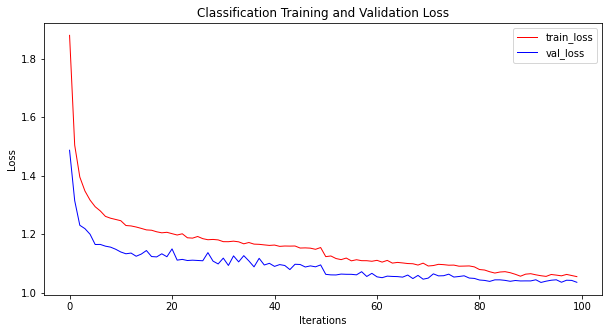

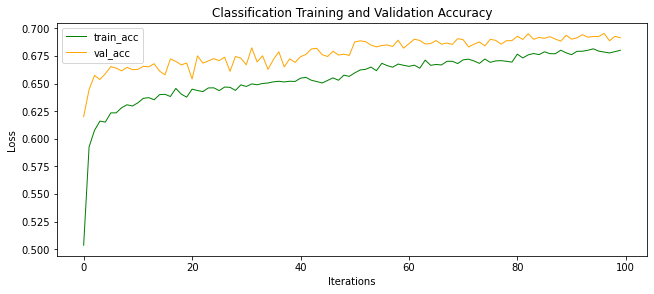

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Classification Training and Validation Loss")
plt.plot(train_loss_clf, label="train_loss", color='red', linewidth=1.0)
plt.plot(val_loss_clf, label="val_loss", color='blue', linewidth=1.0)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()


plt.figure(figsize=(10,5))
plt.title("Classification Training and Validation Accuracy")
plt.plot(train_accuracy_clf, label="train_acc", color='green', linewidth=1.0)
plt.plot(val_accuracy_clf, label="val_acc", color='orange', linewidth=1.0)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout(4)
plt.show()

## **Test**

In [167]:
model = Classifier(args.dim, len(labels))
model.load_state_dict(best_val_model)
model = model.to(device)
pred_origins = [0]*len(labels)
origins = list(labels.keys())
test_origins = []
model.eval()

for batch_idx, data in enumerate(test_clf_dataloader):
  x = data['recipe'].to(device=device)
  pred = model(x)
  pred = pred.type(torch.float).to(device)
  pred = torch.argmax(torch.log_softmax(pred, 1), 1).tolist()
  for idx in pred:
    test_origins.append(origins[idx])
    pred_origins[idx] += 1

In [174]:
pd.DataFrame(test_origins, columns = ["origin"]).to_csv(os.path.join(results, "test_classification_answer.csv"))

In [ ]:
fig1 = px.bar(x = list(labels.keys()), y = pred_origins, text_auto='.2s')
fig1.update_layout(
    xaxis={'categoryorder':'total descending'},
    xaxis_title="Origin",
    yaxis_title = "Frequency",
    title="Predicted Origins and their frequency",
    template="plotly_dark")
fig1.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig1

In [99]:
fig2 = px.bar(x = list(labels.keys()), y = list(np.sum(node_features, axis = 0)), text_auto='.2s')
fig2.update_layout(
    xaxis={'categoryorder':'total descending'},
    title="Each countries distribution",
    template="plotly_dark")
fig2.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig2

# **Completion**

## **Data Loader**

In [75]:
def load_data_completion(embedding, dim, stage):
  emb = []
  target = []
  if stage == "train":
    with open ("train.csv", "r") as f:
      data = f.readlines()      
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")[:-1]
        ingredients = [int(x) for x in ingredients]
        
        # Randomly pop one ingredient and make it target
        random.shuffle(ingredients)

        missing = ingredients.pop()
        merge = np.zeros((len(ingredients), dim))        
        for j in range(len(ingredients)):
          merge[j, :] = embedding.iloc[ingredients[j], :]
        merge = np.sum(merge, axis=0)
        emb.append(merge)
        target.append(embedding.iloc[missing, :])
    
  elif stage == "val":
    with open ("validation_completion_answer.csv", "r") as f:
      data = f.readlines()
      for i in range(len(data)):
        target.append(embedding.iloc[int(data[i]), :])
    
    with open ("validation_completion_question.csv", "r") as f:
      data = f.readlines()
      
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        ingredients = [int(x) for x in ingredients]
        merge = np.zeros((len(ingredients), dim))
        for j in range(len(ingredients)):
          merge[j, :] = embedding.iloc[ingredients[j], :]
        merge = np.sum(merge, axis=0)
        emb.append(merge)
    
  elif stage == "test":
    with open ("test_completion_question.csv", "r") as f:
      data = f.readlines()
      for i in range(len(data)):
        ingredients = data[i].strip().split(",")
        ingredients = [int(x) for x in ingredients]
        merge = np.zeros((len(ingredients), dim))
        
        for j in range(len(ingredients)):
          merge[j, :] = embedding.iloc[ingredients[j], :]
        merge = np.sum(merge, axis=0) 
        emb.append(merge)
        target.append(np.zeros(dim))

  return np.vstack(emb), np.vstack(target)

## **Model**

In [76]:
class Generator(nn.Module):
  def __init__(self, num_feature, latent_dim):
    super(Generator, self).__init__()    
    self.fc1 = nn.Linear(num_feature + latent_dim, 64)
    self.bn1 = nn.BatchNorm1d(64)
    
    self.fc2 = nn.Linear(64, 32)
    self.bn2 = nn.BatchNorm1d(32)

    self.fc3 = nn.Linear(32, 2*num_feature)
    self.bn3 = nn.BatchNorm1d(2*num_feature)

    self.dp = nn.Dropout(0.5)
    self.act = nn.LeakyReLU(0.2)

  def forward(self, x):
    output = self.dp(self.act(self.bn1(self.fc1(x))))
    output = self.dp(self.act(self.bn2(self.fc2(output))))
    output = self.bn3(self.fc3(output))
    return torch.tanh(output)

class Discriminator(nn.Module):
  def __init__(self, num_feature):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(2*num_feature, 512)
    self.bn1 = nn.BatchNorm1d(512)
    
    self.fc2 = nn.Linear(512, 64)
    self.bn2 = nn.BatchNorm1d(64)

    self.fc3 = nn.Linear(64, 1)

    self.dp = nn.Dropout(0.5)
    self.act = nn.LeakyReLU(0.2)

  def forward(self, x):
    output = self.dp(self.act(self.bn1(self.fc1(x))))
    output = self.dp(self.act(self.bn2(self.fc2(output))))
    output = self.fc3(output)

    return torch.sigmoid(output)


class GANclassifier(nn.Module):
  def __init__(self, num_feature):
    super(GANclassifier, self).__init__()
    self.fc1 = nn.Linear(2*num_feature, 512)
    self.bn1 = nn.BatchNorm1d(512)
    
    self.fc2 = nn.Linear(512, 256)
    self.bn2 = nn.BatchNorm1d(256)

    self.fc3 = nn.Linear(256, num_feature)
    self.bn3 = nn.BatchNorm1d(num_feature)

    self.dp = nn.Dropout(0.5)
    self.act = nn.ReLU()

  def forward(self, x):
    output = self.dp(self.act(self.bn1(self.fc1(x))))
    output = self.dp(self.act(self.bn2(self.fc2(output))))
    output = self.act(self.bn3(self.fc3(output)))

    return output

## **Training**

In [77]:
x_train_com_dataset, y_train_com_dataset = load_data_completion(embeddings, args.pred_dim, "train")
x_val_com_dataset, y_val_com_dataset = load_data_completion(embeddings, args.pred_dim, "val")
x_test_com_dataset, y_test_com_dataset = load_data_completion(embeddings, args.pred_dim, "test")

train_com_dataset = MyDataset(x_train_com_dataset, y_train_com_dataset)
val_com_dataset = MyDataset(x_val_com_dataset, y_val_com_dataset)
test_com_dataset = MyDataset(x_test_com_dataset, y_test_com_dataset)


train_com_dataloader = torch.utils.data.DataLoader(train_com_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
val_com_dataloader = torch.utils.data.DataLoader(val_com_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
test_com_dataloader = torch.utils.data.DataLoader(test_com_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)

In [78]:
classifier_loss = torch.nn.MSELoss()
adversarial_loss = torch.nn.BCELoss()
generator = Generator(args.pred_dim, args.latent_dim).to(device)
discriminator = Discriminator(args.pred_dim).to(device)
classifier = GANclassifier(args.pred_dim).to(device)

In [79]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.pred_lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.pred_lr, betas=(args.b1, args.b2))
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=args.pred_lr, weight_decay=0.0001)
scheduler_pred = torch.optim.lr_scheduler.MultiStepLR(optimizer_C, milestones=[50,80], gamma=0.5)

In [80]:
G_losses = []
D_losses = []
C_losses = []
V_losses = []
for epoch in range(args.pred_epochs):
  for batch_idx, data in enumerate(train_com_dataloader):
    recipe_emb = data['recipe'].to(device)
    mis_recipe = data['label'].to(device)

    valid_label = Variable(torch.FloatTensor(recipe_emb.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    fake_label = Variable(torch.FloatTensor(recipe_emb.shape[0], 1).fill_(0.0), requires_grad=False).to(device)

    noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (recipe_emb.shape[0], args.latent_dim)))).to(device)
    # noise = Variable(torch.FloatTensor(np.full((recipe_emb.shape[0], args.latent_dim), 0.001))).to(device)
    fake = generator(torch.cat((noise, recipe_emb), dim=1))


    optimizer_D.zero_grad()
    optimizer_C.zero_grad()

    real_score_out = discriminator(torch.cat((mis_recipe, recipe_emb), dim=1))
    fake_score_out = discriminator(fake.detach())
    real_embedding = classifier(torch.cat((mis_recipe, recipe_emb), dim=1))

    D_real_loss = adversarial_loss(real_score_out, valid_label)
    D_fake_loss = adversarial_loss(fake_score_out, fake_label)
    C_real_loss = classifier_loss(real_embedding, mis_recipe)
  
    d_loss = (D_real_loss + D_fake_loss + C_real_loss) / 3
    d_loss.backward()

    optimizer_D.step()
    optimizer_C.step()

    # -----------------
    #  Train Generator
    # -----------------

    optimizer_G.zero_grad()
    
    fake_score_out = discriminator(fake)
    fake_embedding = classifier(fake)
    
    GD_fake_loss = adversarial_loss(fake_score_out, valid_label)
    GC_fake_loss = classifier_loss(fake_embedding, fake[:, :args.pred_dim])
    
    g_loss = (GD_fake_loss + GC_fake_loss) / 2
    g_loss.backward()
    
    optimizer_G.step()

    if batch_idx % 50 == 0:
      print(
      "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss: %f]"
      % (epoch, args.pred_epochs, batch_idx, len(train_com_dataloader), d_loss.item(), g_loss.item(), C_real_loss.item() )
      )

  # Save Losses for plotting later
  G_losses.append(g_loss.item())
  D_losses.append(d_loss.item())
  C_losses.append(C_real_loss.item())

  generator.eval()
  with torch.no_grad():
    val_loss = []
    for batch_idx, data in enumerate(val_com_dataloader):
      recipe_emb = data['recipe'].to(device=device)
      mis_recipe = data['label'].to(device=device)

      #   Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
      noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (recipe_emb.shape[0], args.latent_dim)))).to(device)
      generated = generator(torch.cat((noise, recipe_emb), dim=1))
      generated = generated.type(torch.float).to(device)
      partition = classifier(generated)

      loss = classifier_loss(partition, mis_recipe) # generated[:, :args.pred_dim]
      val_loss.append(loss)
    
    mean_val_loss = sum(val_loss) / len(val_loss)
    V_losses.append(mean_val_loss.item())

[Epoch 0/50] [Batch 0/368] [D loss: 0.671400] [G loss: 0.805886] [C loss: 0.585326]
[Epoch 0/50] [Batch 50/368] [D loss: 0.708497] [G loss: 0.802702] [C loss: 0.587287]
[Epoch 0/50] [Batch 100/368] [D loss: 0.710865] [G loss: 0.798243] [C loss: 0.599361]
[Epoch 0/50] [Batch 150/368] [D loss: 0.663439] [G loss: 0.794011] [C loss: 0.573668]
[Epoch 0/50] [Batch 200/368] [D loss: 0.701150] [G loss: 0.817974] [C loss: 0.573722]
[Epoch 0/50] [Batch 250/368] [D loss: 0.690020] [G loss: 0.827995] [C loss: 0.566031]
[Epoch 0/50] [Batch 300/368] [D loss: 0.704597] [G loss: 0.800223] [C loss: 0.560431]
[Epoch 0/50] [Batch 350/368] [D loss: 0.675003] [G loss: 0.815930] [C loss: 0.563729]
[Epoch 1/50] [Batch 0/368] [D loss: 0.695024] [G loss: 0.669772] [C loss: 0.550497]
[Epoch 1/50] [Batch 50/368] [D loss: 0.678777] [G loss: 0.660935] [C loss: 0.558782]
[Epoch 1/50] [Batch 100/368] [D loss: 0.698557] [G loss: 0.674058] [C loss: 0.565829]
[Epoch 1/50] [Batch 150/368] [D loss: 0.663105] [G loss: 0.6

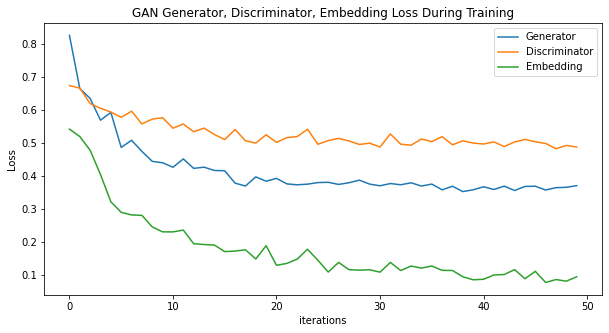

In [81]:
plt.figure(figsize=(10,5))
plt.title("GAN Generator, Discriminator, Embedding Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.plot(C_losses, label="Embedding")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

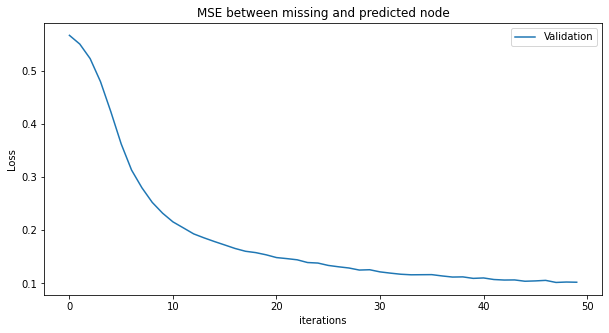

In [82]:
plt.figure(figsize=(10,5))
plt.title("MSE between missing and predicted node")
plt.plot(V_losses, label="Validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## **Test**

In [83]:
missing_nodes_embeddings = []
generator.eval()
classifier.eval()

for recipe_emb in x_val_com_dataset:
  recipe_emb = data['recipe'].to(device)
  # noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (recipe_emb.shape[0], args.latent_dim)))).to(device)
  noise = Variable(torch.FloatTensor(np.full((recipe_emb.shape[0], args.latent_dim), 0.001))).to(device)
  generated = generator(torch.cat((noise, recipe_emb), dim=1))
  generated = generated.type(torch.float).to(device)
  partition = classifier(generated)
  missing_nodes_embeddings.append(partition)

missing_nodes_embeddings = torch.cat(missing_nodes_embeddings, dim=0)

In [84]:
missing_nodes_embeddings = missing_nodes_embeddings.cpu().detach().numpy()

In [85]:
def L2_loop_function(X_test, X_train):
  test_data_shape = X_test.shape[0]
  train_data_shape = X_train.shape[0]
  distances = np.zeros((test_data_shape, train_data_shape))

  for i in range(test_data_shape):
      distances[i, :] = np.sum((X_train - X_test[i, :]) ** 2, axis = 1) #no need to sqrt as it causes the same effect

  return distances

def L2_vectorized_function(X_test, X_train):
  X_test_squared = np.sum(np.square(X_test), axis=1, keepdims=True)
  X_train_squared = np.sum(np.square(X_train), axis=1, keepdims=True)
  X_test_X_train = np.dot(X_test, X_train.T)

  return X_test_squared - (2 * X_test_X_train) + X_train_squared.T

def predict_missing_node(X_test, X_train, typ=0):
  if typ == 0:
      method = L2_vectorized_function(X_test, X_train)
  else:
      method = L2_loop_function(X_test, X_train)
  nodes = np.argmin(method, axis=1)
  return nodes

In [86]:
def val_completion_missing():
  target = []
  with open ("validation_completion_answer.csv", "r") as f:
    data = f.readlines()
    for i in range(len(data)):
      target.append(int(data[i]))
  return target
  
val_missing_nodes = val_completion_missing()

In [87]:
pred_missing_nodes = predict_missing_node(missing_nodes_embeddings, embeddings.to_numpy(), 1).tolist()

In [88]:
count = 0
for i, j in zip(pred_missing_nodes, val_missing_nodes):
  if i == j:
    count += 1
print(f"Matched: {count} Validation accuracy: {(count/len(val_missing_nodes))*100:.4} %")

Matched: 0 Validation accuracy: 0.0 %


## **KNN**

In [97]:
output = predict_missing_node(x_val_com_dataset, embeddings.to_numpy())

In [95]:
count = 0
for i, j in zip(val_missing_nodes, output.tolist()):
  if i == j:
    count += 1
print(f"Matched: {count} Validation accuracy: {(count/len(val_missing_nodes))*100:.4} %")

Validation accuracy: 0.0 %


In [71]:
output_ = predict_missing_node(x_test_com_dataset, scaled_node_features)

In [72]:
pd.DataFrame(output_.tolist(), columns = ["ingredient"]).to_csv(os.path.join(results, "test_completion_answer.csv"))